# Project Name: Facial Recognition with Eigenfaces: Implement PCA to build an Eigenfaces-based facial recognition system

## Overview
A security company wants to develop an automated facial recognition system for access control and identity verification. Traditional facial recognition approaches suffer from high dimensionality and computational complexity when processing raw pixel data from face images.

You have:
● High-dimensional facial image data from the Labeled Faces in the Wild (LFW) dataset
● Multiple face images per person with varying lighting conditions, poses, and expressions
● Pixel-level features that create a very large feature space (thousands of dimensions)
● Need for real-time processing and accurate classification

We will:
1. Apply Principal Component Analysis (PCA) to extract eigenfaces - the most significant facial features that capture maximum variance
2. Reduce dimensionality from thousands of pixels to a manageable number of principal components (150 components)
3. Transform the high-dimensional face data into a lower-dimensional eigenface space
4. Train a Support Vector Machine (SVM) classifier on the reduced feature space
5. Evaluate classification performance and visualize the learned eigenfaces

## Goal
Security teams can use this system for automated access control, surveillance applications, and identity verification with improved computational efficiency and accuracy. The eigenfaces approach reduces storage requirements, speeds up processing time, and maintains high recognition accuracy by focusing on the most discriminative facial features.

#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from time import time
import base64
from IPython.display import display, HTML
import os

#### Notebook utility

In [5]:
image_paths = ["PCA3.png", "PCA4.webp", "PCA5.webp","PCA6.png"]
image_size = [500, 400, 600, 500]
images_html = []

mime_map = {
    ".png": "image/png",
    ".jpg": "image/jpeg",
    ".jpeg": "image/jpeg",
    ".gif": "image/gif",
    ".webp": "image/webp"
}

for i, path in enumerate(image_paths):
    ext = os.path.splitext(path)[1].lower()
    mime = mime_map.get(ext, "image/png")

    with open("../img/"+path, "rb") as f:
        data = f.read()
    encoded = base64.b64encode(data).decode("utf-8")

    img_tag = f'<img src="data:{mime};base64,{encoded}" style="display: block; margin-left: auto; margin-right: auto; width: {image_size[i]}px;" /><br>'
    images_html.append(img_tag)


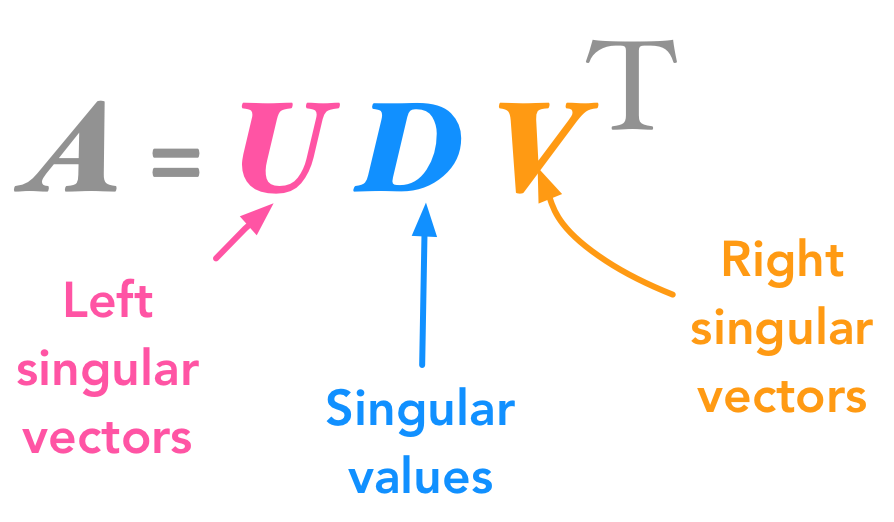

In [6]:
display(HTML(images_html[0]))


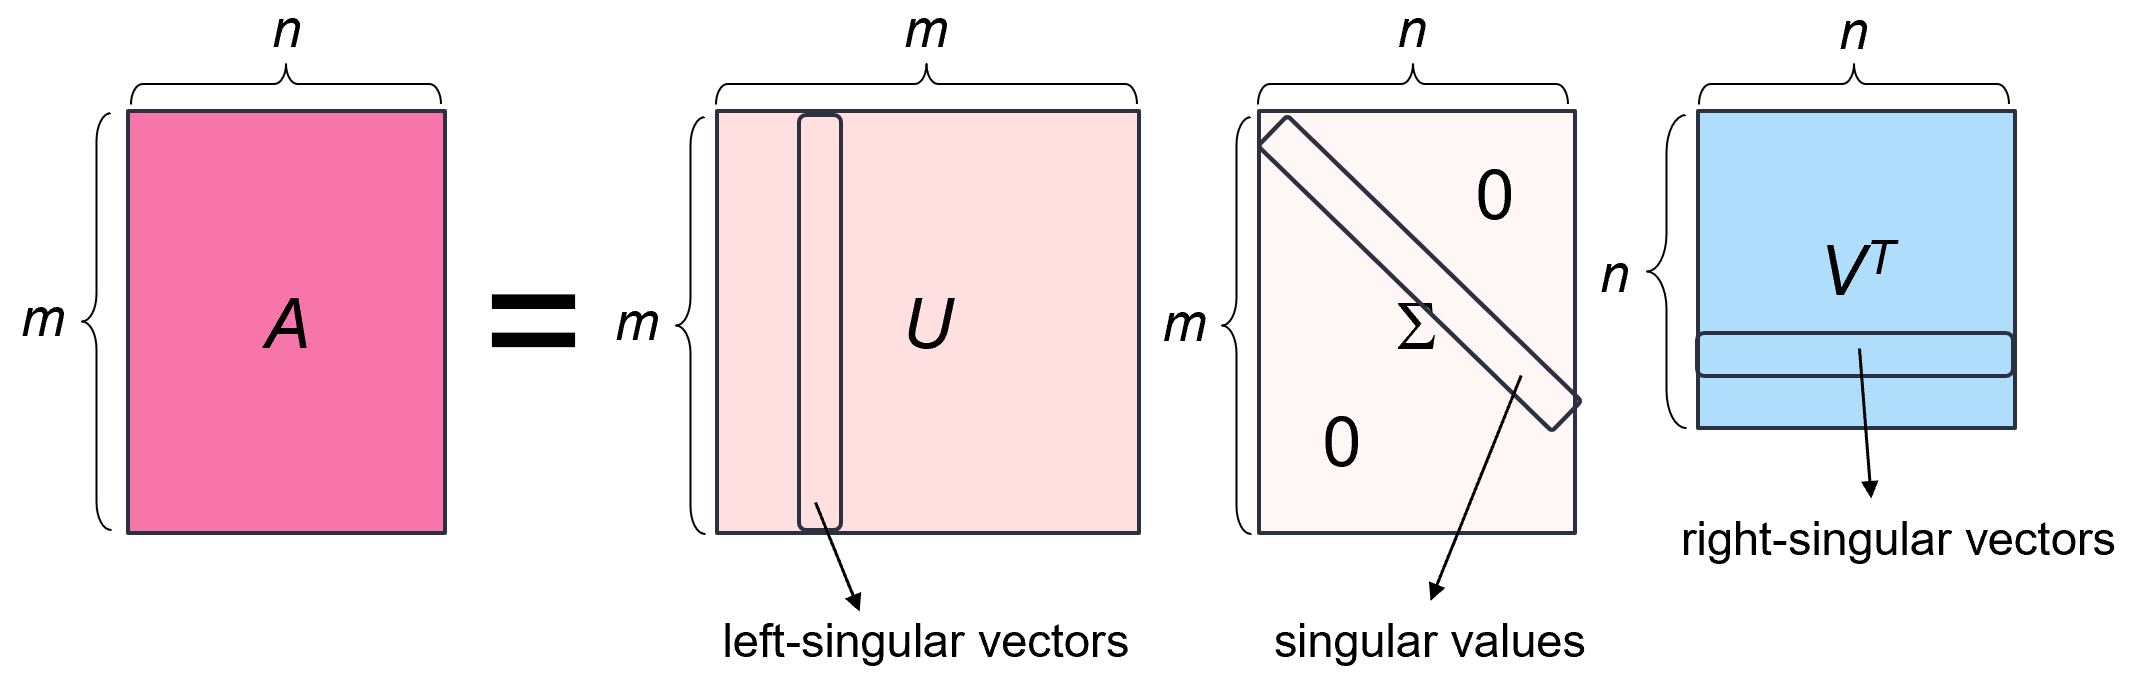

In [7]:
display(HTML(images_html[1]))


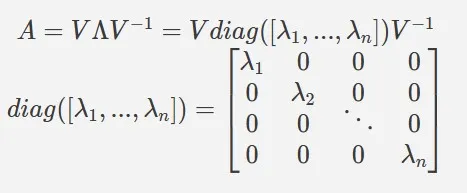

In [8]:
display(HTML(images_html[2]))


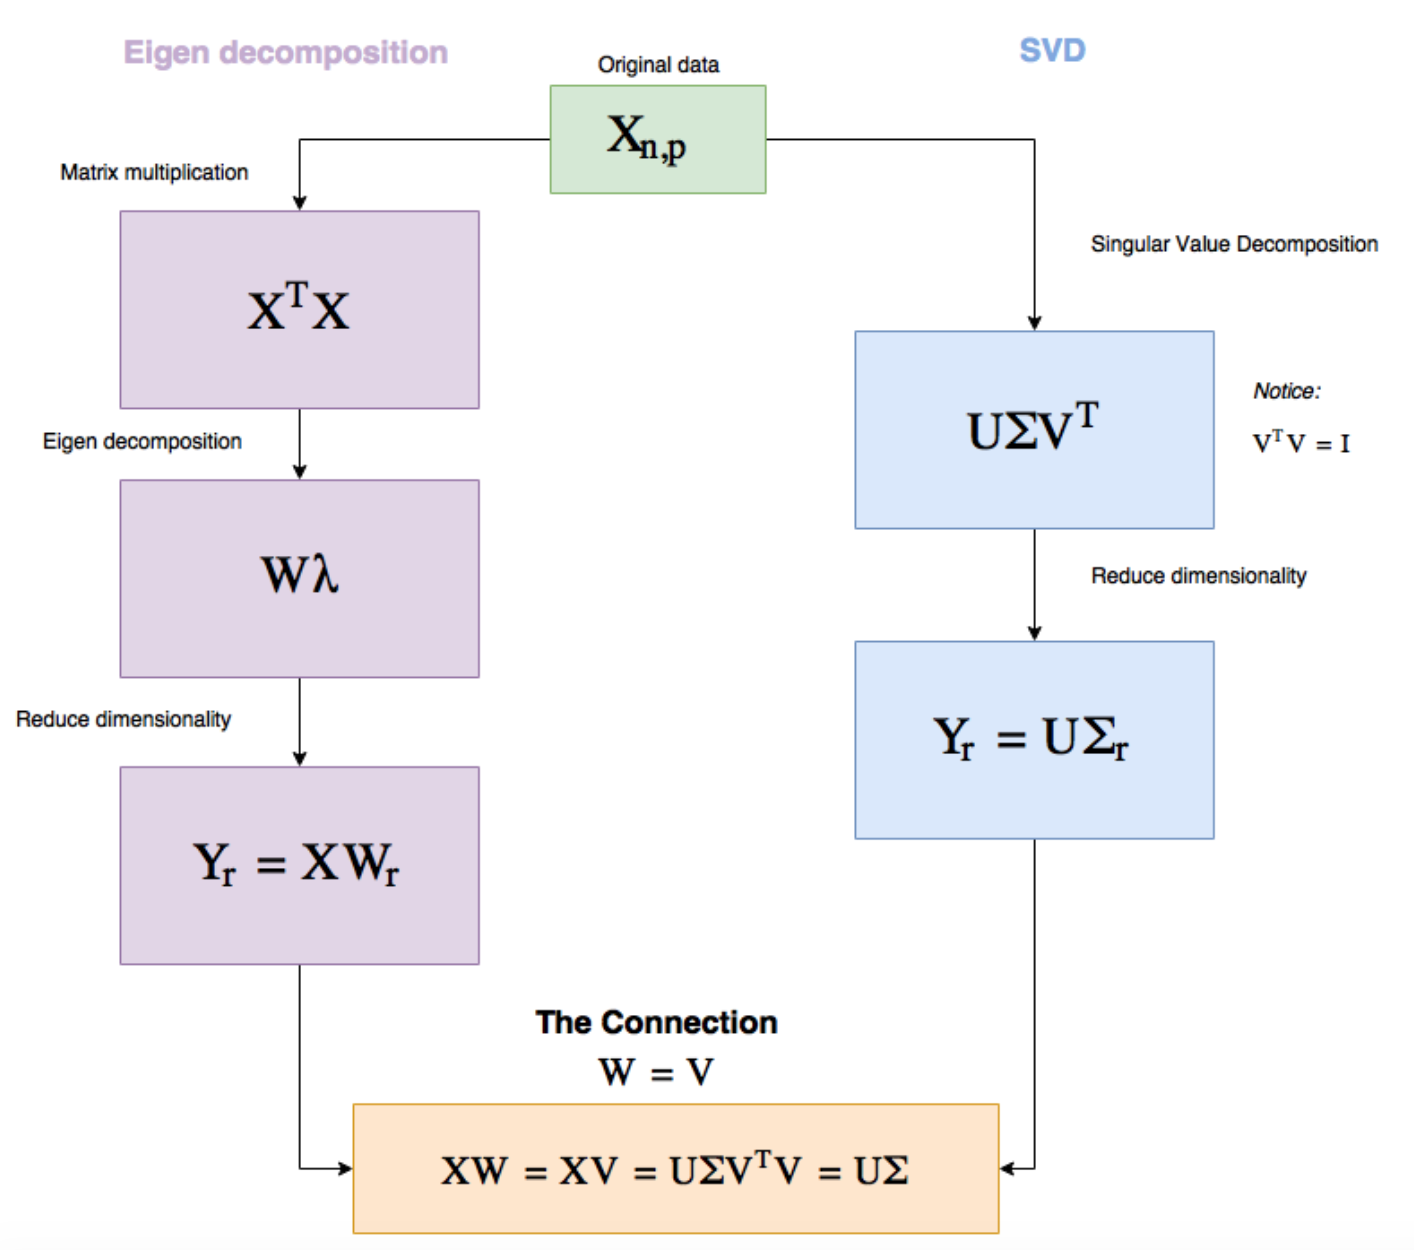

In [9]:
display(HTML(images_html[3]))

#### Load the Dataset

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Image shape: 50x37


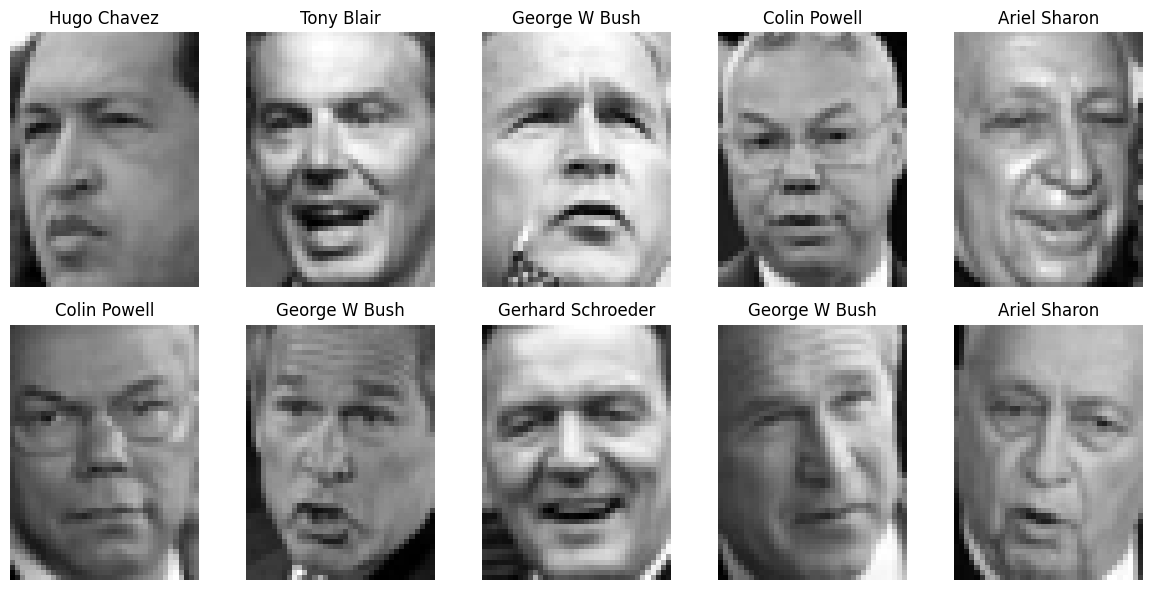

In [2]:
# Load LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Dataset information
n_samples, h, w = lfw_people.images.shape
n_features = lfw_people.data.shape[1]
n_classes = len(lfw_people.target_names)

print(f"Total dataset size:")
print(f"n_samples: {n_samples}")
print(f"n_features: {n_features}")
print(f"n_classes: {n_classes}")
print(f"Image shape: {h}x{w}")

# Display sample faces
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(lfw_people.images[i], cmap='gray')
    ax.set_title(lfw_people.target_names[lfw_people.target[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()


#### Pre-processing and Splitting Dataset into Train-Test 

In [ ]:
X = lfw_people.data  # Already flattened
y = lfw_people.target
target_names = lfw_people.target_names

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 966
Test set size: 322


#### Apply PCA

In [5]:
# Apply PCA (Eigenfaces)
n_components = 150

print(f"Extracting the top {n_components} eigenfaces from {X_train.shape[0]} faces")
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True)
pca.fit(X_train)
print(f"PCA fitting done in {time() - t0:.3f}s")

# Transform data
print("Projecting input data on eigenfaces basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"Projection done in {time() - t0:.3f}s")

print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")
print(f"Reduced feature dimensions: {X_train_pca.shape[1]}")


Extracting the top 150 eigenfaces from 966 faces
PCA fitting done in 0.119s
Projecting input data on eigenfaces basis
Projection done in 0.003s
Explained variance ratio: 0.946
Reduced feature dimensions: 150


#### Visualize Eigenfaces

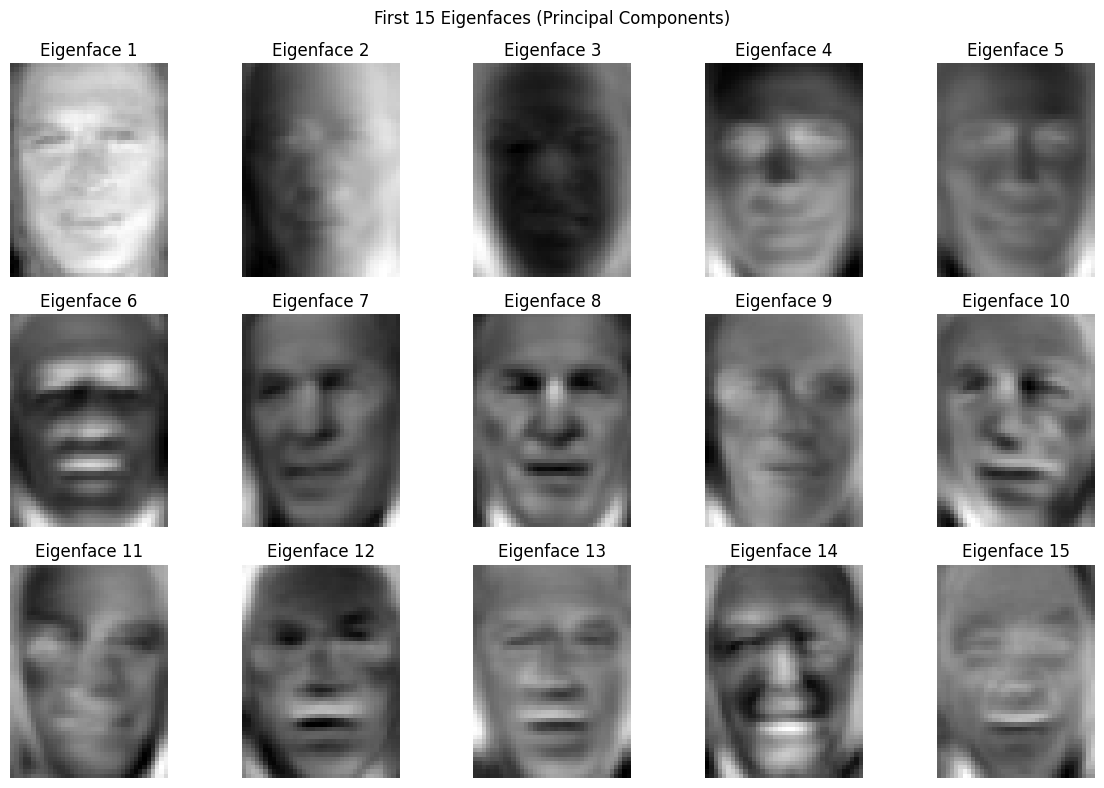

In [6]:
# Visualize Eigenfaces
eigenfaces = pca.components_.reshape((n_components, h, w))

fig, axes = plt.subplots(3, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
    ax.axis('off')
plt.suptitle("First 15 Eigenfaces (Principal Components)")
plt.tight_layout()
plt.show()


#### Train SVM classifier with GridSearchCV


In [ ]:
print("Fitting classifier to training set")
t0 = time()

param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
}

clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'),
    param_grid,
    cv=5,
    n_jobs=-1
)

clf.fit(X_train_pca, y_train)
print(f"Training done in {time() - t0:.3f}s")
print(f"Best estimator found by grid search:")
print(clf.best_estimator_)


Fitting classifier to training set
Training done in 3.521s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


#### Make predictions and evaluate


Predicting people's names on test set
Prediction done in 0.076s
Accuracy: 0.857

Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.74      0.82        19
     Colin Powell       0.89      0.93      0.91        59
  Donald Rumsfeld       0.88      0.70      0.78        30
    George W Bush       0.81      0.96      0.88       133
Gerhard Schroeder       0.86      0.70      0.78        27
      Hugo Chavez       1.00      0.50      0.67        18
       Tony Blair       0.94      0.83      0.88        36

         accuracy                           0.86       322
        macro avg       0.90      0.77      0.82       322
     weighted avg       0.87      0.86      0.85       322



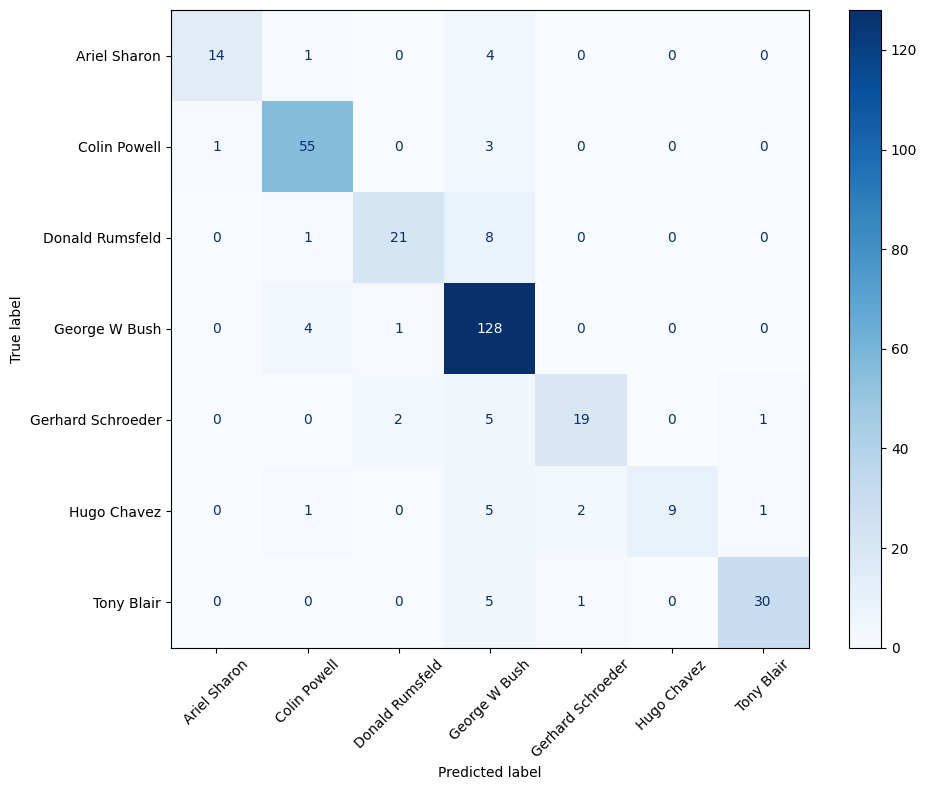

In [ ]:
print("Predicting people's names on test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print(f"Prediction done in {time() - t0:.3f}s")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Visualizing some predictions


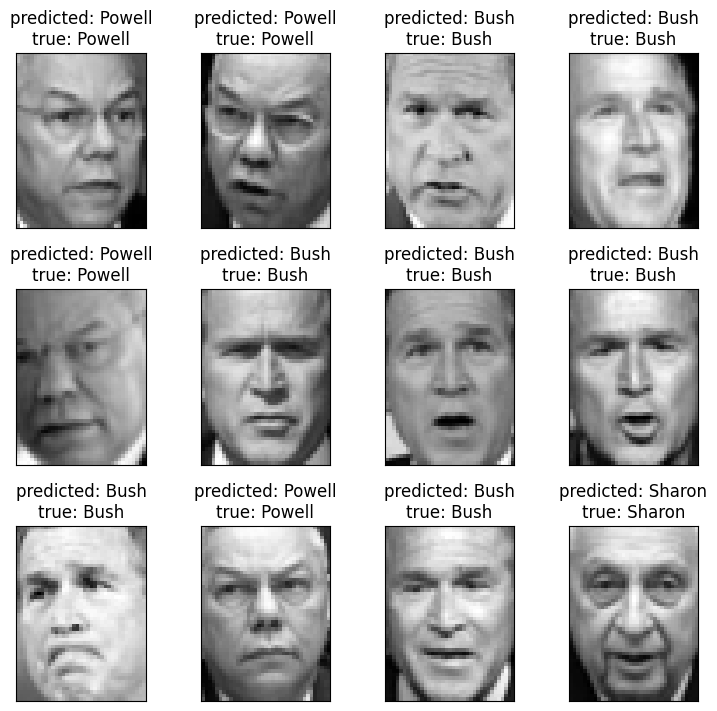

In [ ]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return f'predicted: {pred_name}\ntrue: {true_name}'

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)
plt.show()


## Conclusion

PCA (Eigenfaces) successfully reduced the dimensionality from the original feature space to 150 components while retaining most of the variance in the data. This dimensionality reduction made the classification faster and more effective by:

1. Reducing computational complexity
2. Eliminating noise and focusing on the most important facial features
3. Enabling efficient storage and processing of face data
4. Maintaining good classification accuracy with significantly fewer features

The eigenfaces represent the principal directions of variation in the face dataset, capturing the essential characteristics needed for face recognition.
